In [1]:
!pip install tensorflow==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninst

In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 00:18:57--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.140.40, 54.231.227.168, 52.217.122.56, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.140.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  57.7MB/s    in 0.2s    

2024-04-07 00:18:58 (57.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset - 420451 rows and 15 Features**

In [4]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Parsing the data- converting the comma-separated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis.**

In [5]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

Text(0, 0.5, 'Temperature')

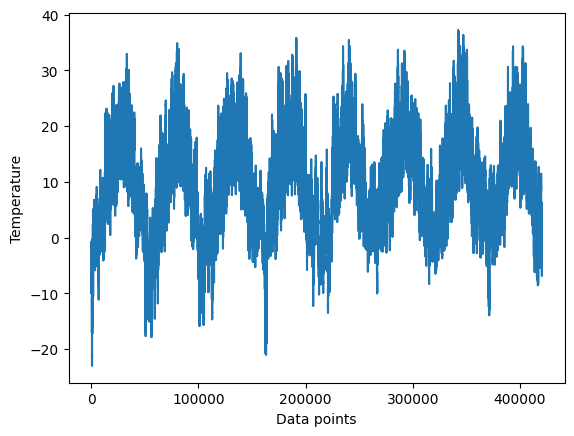

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Plotting the first 10 days of the temperature timeseries- As given that one day data has 144 data points hence 10days will have 1440 data points**

Text(0, 0.5, 'Temperature')

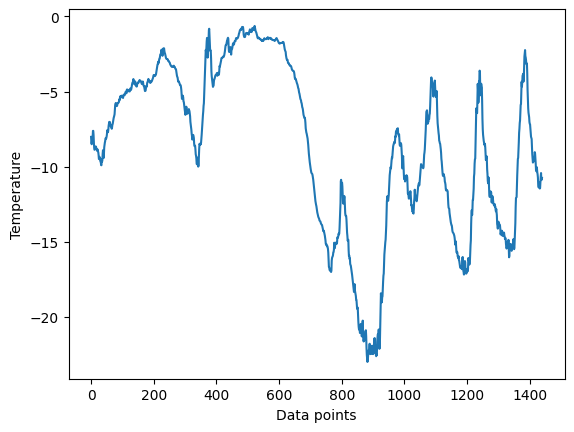

In [7]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Computing the number of samples we'll use for each data split- 50% for Train, 25%- validation**

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


# **Preparing the data**

**Normalizing the data- Since the data is already in a numerical format, vectorization is unnecessary. However, given that the data scales differ across variables, with temperature ranging from -20 to +30 and pressure measured in millibars, it is advisable to standardize all variables.**

In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [11]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing - it is required because the samples in the dataset are highly redundant Hence, it would be inefficient to allocate memory for each sample explicitly. Instead, we will generate the samples dynamically.**

In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


# **A common-sense, non-machine-learning baseline**

**Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.**

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Common-sense baseline approach is to predict that the temperature 24 hours ahead will be identical to the current temperature. By using this straightforward baseline, the validation MAE (Mean Absolute Error) is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. In other words, assuming that the temperature in the future remains the same as the current temperature would result in an average deviation of approximately two and a half degrees.

# **A basic machine-learning model - Dense Layer**

**Training and evaluating a densely connected model**

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [17]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 49s 58ms/step - loss: 12.0966 - mae: 2.6877 - val_loss: 11.2644 - val_mae: 2.6574
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 8.7591 - mae: 2.3288 - val_loss: 11.3583 - val_mae: 2.6713
Epoch 3/10
819/819 [==============================] - 57s 69ms/step - loss: 8.0575 - mae: 2.2348 - val_loss: 10.3659 - val_mae: 2.5448
Epoch 4/10
819/819 [==============================] - 55s 66ms/step - loss: 7.6087 - mae: 2.1739 - val_loss: 12.2755 - val_mae: 2.7762
Epoch 5/10
819/819 [==============================] - 52s 63ms/step - loss: 7.2928 - mae: 2.1289 - val_loss: 11.0961 - val_mae: 2.6300
Epoch 6/10
819/819 [==============================] - 49s 59ms/step - loss: 7.0350 - mae: 2.0931 - val_loss: 11.1941 - val_mae: 2.6441
Epoch 7/10
819/819 [==============================] - 49s 59ms/step - loss: 6.8404 - mae: 2.0629 - val_loss: 11.4156 - val_mae: 2.6644
Epoch 8/10
819/819 [==============================] - 

In [20]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 16s 39ms/step - loss: 11.4217 - mae: 2.6437
Test MAE: 2.64


**Plotting results**

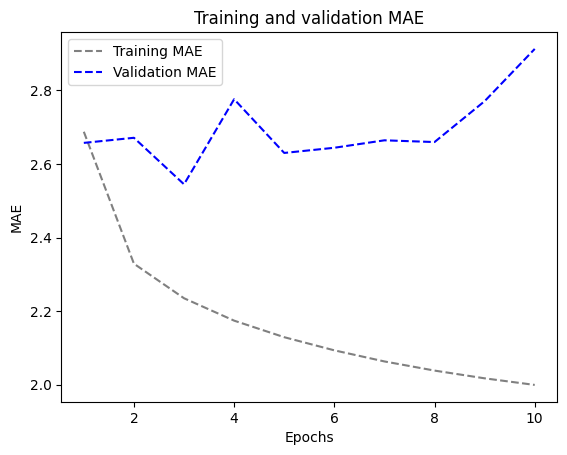

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# **Let's try a 1D convolutional model**

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 86s 103ms/step - loss: 23.7746 - mae: 3.8034 - val_loss: 22.4870 - val_mae: 3.7098
Epoch 2/10
819/819 [==============================] - 82s 99ms/step - loss: 15.8125 - mae: 3.1647 - val_loss: 14.8130 - val_mae: 3.0623
Epoch 3/10
819/819 [==============================] - 83s 101ms/step - loss: 14.2417 - mae: 2.9972 - val_loss: 14.3072 - val_mae: 2.9666
Epoch 4/10
819/819 [==============================] - 88s 107ms/step - loss: 13.3576 - mae: 2.8977 - val_loss: 20.1665 - val_mae: 3.5454
Epoch 5/10
819/819 [==============================] - 89s 108ms/step - loss: 12.8322 - mae: 2.8407 - val_loss: 14.2670 - val_mae: 2.9668
Epoch 6/10
819/819 [==============================] - 89s 109ms/step - loss: 12.4519 - mae: 2.7954 - val_loss: 14.0571 - val_mae: 2.9485
Epoch 7/10
819/819 [==============================] - 123s 150ms/step - loss: 12.0873 - mae: 2.7547 - val_loss: 13.9501 - val_mae: 2.9565
Epoch 8/10
819/819 [=====================

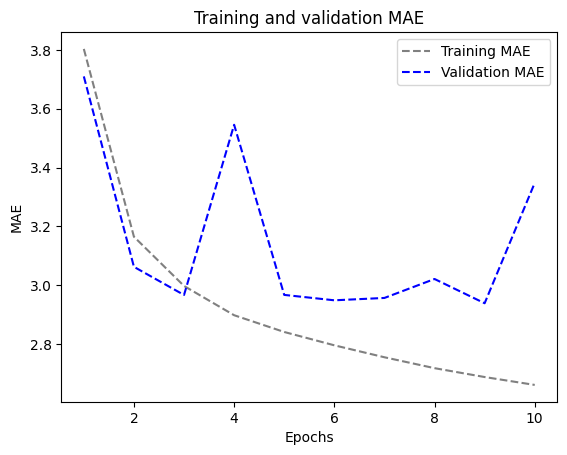

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

It seem that the convolutional data perform worse compared to common sense or dense model. it could be because

- The assumption of translation invariance does not hold well for weather data.

- The order of the data is crucial. Recent past data is significantly more informative for predicting the temperature of the following day compared to data from several days ago. Unfortunately, a 1D convolutional neural network is unable to effectively capture this critical temporal order.

# **A Simple RNN**

**1.An RNN layer that can process sequences of any length**

In [24]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 77s 93ms/step - loss: 138.7432 - mae: 9.6939 - val_loss: 144.0067 - val_mae: 9.9023
Epoch 2/10
819/819 [==============================] - 75s 91ms/step - loss: 136.3165 - mae: 9.5548 - val_loss: 143.8013 - val_mae: 9.8819
Epoch 3/10
819/819 [==============================] - 78s 94ms/step - loss: 136.2390 - mae: 9.5478 - val_loss: 143.6788 - val_mae: 9.8670
Epoch 4/10
819/819 [==============================] - 74s 90ms/step - loss: 136.2022 - mae: 9.5432 - val_loss: 143.6592 - val_mae: 9.8659
Epoch 5/10
819/819 [==============================] - 73s 88ms/step - loss: 136.1734 - mae: 9.5386 - val_loss: 143.5966 - val_mae: 9.8574
Epoch 6/10
819/819 [==============================] - 75s 91ms/step - loss: 136.1472 - mae: 9.5352 - val_loss: 143.5659 - val_mae: 9.8513
Epoch 7/10
819/819 [==============================] - 73s 89ms/step - loss: 136.1489 - mae: 9.5348 - val_loss: 143.5657 - val_mae: 9.8522
Epoch 8/10
819/819 [==============

# **2.Simple RNN - Stacking RNN layers**

In [25]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 135s 161ms/step - loss: 136.9767 - mae: 9.5732 - val_loss: 143.5129 - val_mae: 9.8500
Epoch 2/10
819/819 [==============================] - 130s 159ms/step - loss: 135.9816 - mae: 9.5164 - val_loss: 143.4397 - val_mae: 9.8397
Epoch 3/10
819/819 [==============================] - 127s 155ms/step - loss: 135.9150 - mae: 9.5075 - val_loss: 143.4221 - val_mae: 9.8372
Epoch 4/10
819/819 [==============================] - 128s 155ms/step - loss: 135.8847 - mae: 9.5028 - val_loss: 143.4524 - val_mae: 9.8416
Epoch 5/10
819/819 [==============================] - 145s 177ms/step - loss: 135.8538 - mae: 9.4984 - val_loss: 143.4391 - val_mae: 9.8406
Epoch 6/10
819/819 [==============================] - 143s 175ms/step - loss: 135.8293 - mae: 9.4944 - val_loss: 143.4548 - val_mae: 9.8455
Epoch 7/10
819/819 [==============================] - 128s 156ms/step - loss: 135.8316 - mae: 9.4941 - val_loss: 143.4133 - val_mae: 9.8347
Epoch 8/10
819/819 [

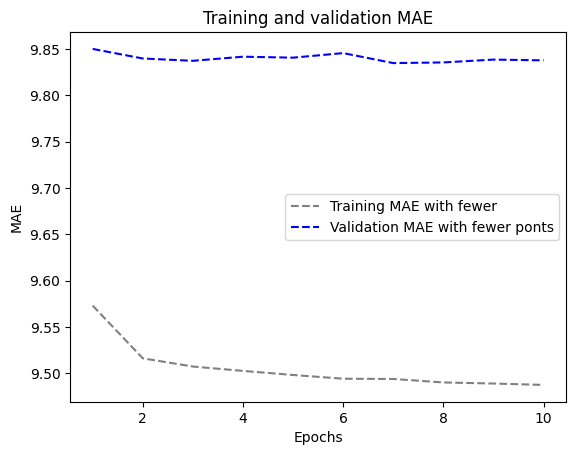

In [27]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE with fewer")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE with fewer ponts")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [28]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(64, return_sequences=True)(inputs)
x = layers.SimpleRNN(64, return_sequences=True)(x)
outputs = layers.SimpleRNN(64)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 284s 344ms/step - loss: 136.2690 - mae: 9.5354 - val_loss: 143.4331 - val_mae: 9.8405
Epoch 2/10
819/819 [==============================] - 239s 292ms/step - loss: 135.9033 - mae: 9.5057 - val_loss: 143.4382 - val_mae: 9.8391
Epoch 3/10
819/819 [==============================] - 280s 341ms/step - loss: 135.8371 - mae: 9.4955 - val_loss: 143.4353 - val_mae: 9.8373
Epoch 4/10
819/819 [==============================] - 281s 343ms/step - loss: 135.7985 - mae: 9.4893 - val_loss: 143.4571 - val_mae: 9.8387
Epoch 5/10
819/819 [==============================] - 281s 342ms/step - loss: 135.7591 - mae: 9.4829 - val_loss: 143.4392 - val_mae: 9.8401
Epoch 6/10
819/819 [==============================] - 278s 339ms/step - loss: 135.7342 - mae: 9.4783 - val_loss: 143.4498 - val_mae: 9.8446
Epoch 7/10
819/819 [==============================] - 279s 340ms/step - loss: 135.7322 - mae: 9.4771 - val_loss: 143.4912 - val_mae: 9.8481
Epoch 8/10
819/819 [

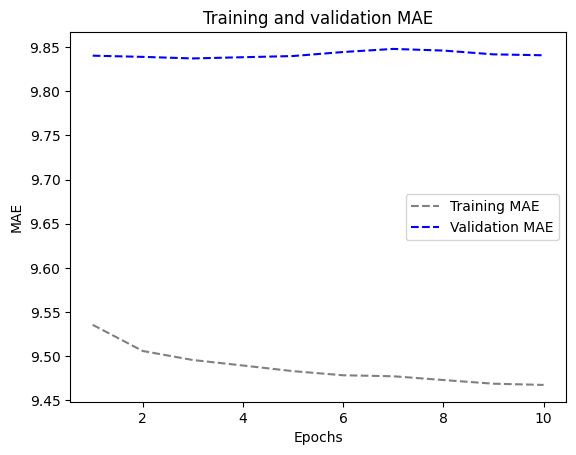

In [29]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [30]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(x)
outputs = layers.SimpleRNN(32)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 174s 209ms/step - loss: 136.3739 - mae: 9.5378 - val_loss: 143.3804 - val_mae: 9.8312
Epoch 2/10
819/819 [==============================] - 157s 191ms/step - loss: 135.8933 - mae: 9.5033 - val_loss: 143.3900 - val_mae: 9.8314
Epoch 3/10
819/819 [==============================] - 164s 200ms/step - loss: 135.8582 - mae: 9.4976 - val_loss: 143.4469 - val_mae: 9.8382
Epoch 4/10
819/819 [==============================] - 173s 211ms/step - loss: 135.8336 - mae: 9.4933 - val_loss: 143.4016 - val_mae: 9.8326
Epoch 5/10
819/819 [==============================] - 168s 204ms/step - loss: 135.8266 - mae: 9.4919 - val_loss: 143.4083 - val_mae: 9.8347
Epoch 6/10
819/819 [==============================] - 163s 199ms/step - loss: 135.8010 - mae: 9.4885 - val_loss: 143.4120 - val_mae: 9.8335
Epoch 7/10
819/819 [==============================] - 169s 205ms/step - loss: 135.7984 - mae: 9.4884 - val_loss: 143.4360 - val_mae: 9.8397
Epoch 8/10
819/819 [

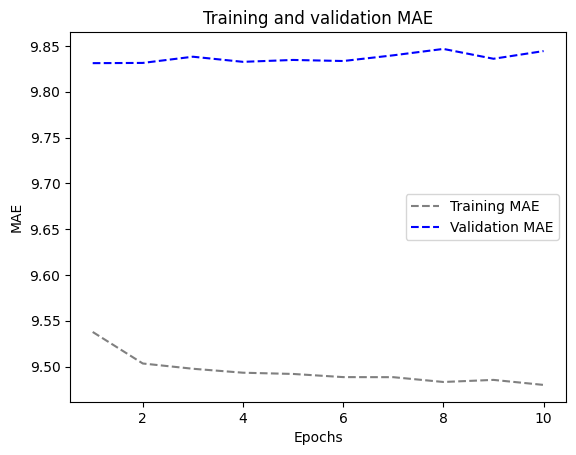

In [31]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# **A Simple GRU (Gated Recurrent Unit)**

In [32]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 126s 151ms/step - loss: 39.2510 - mae: 4.5325 - val_loss: 12.4765 - val_mae: 2.6730
Epoch 2/10
819/819 [==============================] - 104s 127ms/step - loss: 10.6581 - mae: 2.5413 - val_loss: 10.5723 - val_mae: 2.4745
Epoch 3/10
819/819 [==============================] - 107s 130ms/step - loss: 9.6812 - mae: 2.4259 - val_loss: 9.8932 - val_mae: 2.4024
Epoch 4/10
819/819 [==============================] - 125s 151ms/step - loss: 9.2699 - mae: 2.3766 - val_loss: 10.0421 - val_mae: 2.4086
Epoch 5/10
819/819 [==============================] - 126s 153ms/step - loss: 8.9985 - mae: 2.3427 - val_loss: 9.7026 - val_mae: 2.3785
Epoch 6/10
819/819 [==============================] - 127s 154ms/step - loss: 8.7886 - mae: 2.3143 - val_loss: 9.8412 - val_mae: 2.4059
Epoch 7/10
819/819 [==============================] - 106s 129ms/step - loss: 8.6114 - mae: 2.2907 - val_loss: 10.6256 - val_mae: 2.4738
Epoch 8/10
819/819 [======================

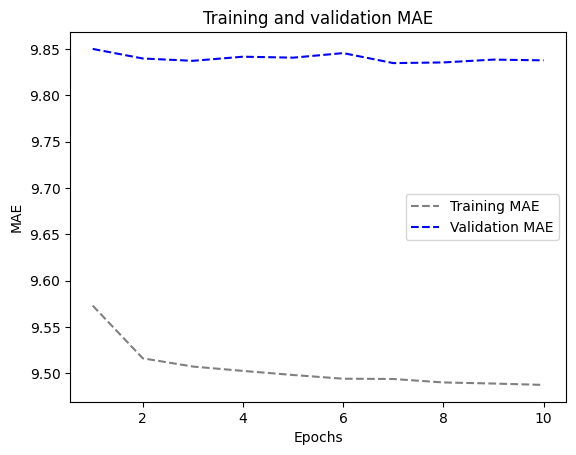

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# **LSTM(Long Short-Term Memory )**

**1.LSTM-Simple**

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 126s 150ms/step - loss: 36.9219 - mae: 4.4073 - val_loss: 11.7273 - val_mae: 2.6338
Epoch 2/10
819/819 [==============================] - 123s 150ms/step - loss: 10.6663 - mae: 2.5346 - val_loss: 9.5305 - val_mae: 2.4149
Epoch 3/10
819/819 [==============================] - 123s 150ms/step - loss: 9.5357 - mae: 2.4025 - val_loss: 9.5538 - val_mae: 2.4018
Epoch 4/10
819/819 [==============================] - 105s 128ms/step - loss: 9.0070 - mae: 2.3401 - val_loss: 9.6338 - val_mae: 2.4227
Epoch 5/10
819/819 [==============================] - 105s 128ms/step - loss: 8.6483 - mae: 2.2976 - val_loss: 9.6704 - val_mae: 2.4317
Epoch 6/10
819/819 [==============================] - 125s 152ms/step - loss: 8.3853 - mae: 2.2625 - val_loss: 9.7288 - val_mae: 2.4412
Epoch 7/10
819/819 [==============================] - 105s 128ms/step - loss: 8.1479 - mae: 2.2311 - val_loss: 9.7713 - val_mae: 2.4514
Epoch 8/10
819/819 [=========================

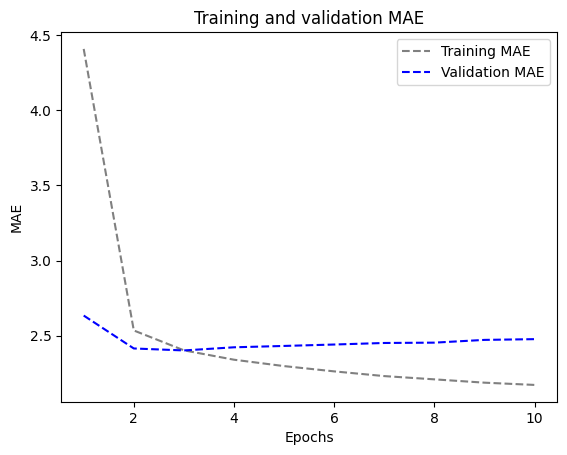

In [34]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**2. LSTM-Dropout Regularization**

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 192s 229ms/step - loss: 49.0892 - mae: 5.2156 - val_loss: 13.5326 - val_mae: 2.7879
Epoch 2/10
819/819 [==============================] - 188s 230ms/step - loss: 20.0311 - mae: 3.4372 - val_loss: 9.8801 - val_mae: 2.4453
Epoch 3/10
819/819 [==============================] - 171s 209ms/step - loss: 18.4131 - mae: 3.3032 - val_loss: 9.6463 - val_mae: 2.4205
Epoch 4/10
819/819 [==============================] - 170s 206ms/step - loss: 17.6769 - mae: 3.2357 - val_loss: 9.4178 - val_mae: 2.3984
Epoch 5/10
819/819 [==============================] - 171s 208ms/step - loss: 16.9887 - mae: 3.1730 - val_loss: 9.1855 - val_mae: 2.3698
Epoch 6/10
819/819 [==============================] - 167s 204ms/step - loss: 16.5439 - mae: 3.1298 - val_loss: 9.2100 - val_mae: 2.3728
Epoch 7/10
819/819 [==============================] - 185s 226ms/step - loss: 16.0833 - mae: 3.0856 - val_loss: 9.3072 - val_mae: 2.3809
Epoch 8/10
819/819 [====================

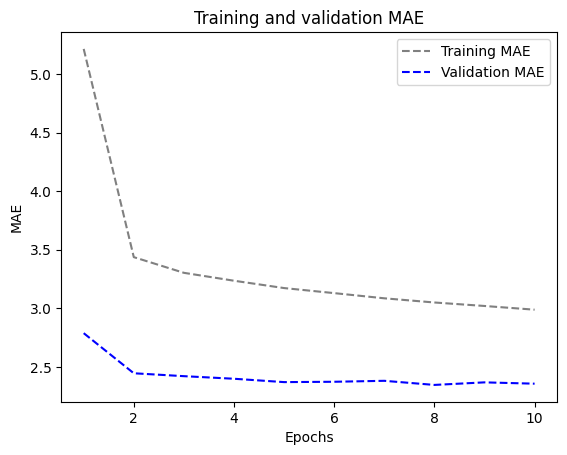

In [36]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**3.LSTM - Stacked setup with 16 units**

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 189s 225ms/step - loss: 38.6083 - mae: 4.5170 - val_loss: 12.0450 - val_mae: 2.6342
Epoch 2/10
819/819 [==============================] - 190s 232ms/step - loss: 10.2072 - mae: 2.4774 - val_loss: 9.5883 - val_mae: 2.4002
Epoch 3/10
819/819 [==============================] - 183s 223ms/step - loss: 8.8359 - mae: 2.3167 - val_loss: 9.6811 - val_mae: 2.4353
Epoch 4/10
819/819 [==============================] - 182s 222ms/step - loss: 8.1514 - mae: 2.2266 - val_loss: 9.7583 - val_mae: 2.4488
Epoch 5/10
819/819 [==============================] - 185s 225ms/step - loss: 7.7511 - mae: 2.1672 - val_loss: 10.3997 - val_mae: 2.5176
Epoch 6/10
819/819 [==============================] - 196s 239ms/step - loss: 7.2186 - mae: 2.0904 - val_loss: 10.7279 - val_mae: 2.5622
Epoch 7/10
819/819 [==============================] - 192s 234ms/step - loss: 6.7921 - mae: 2.0277 - val_loss: 11.4845 - val_mae: 2.6566
Epoch 8/10
819/819 [======================

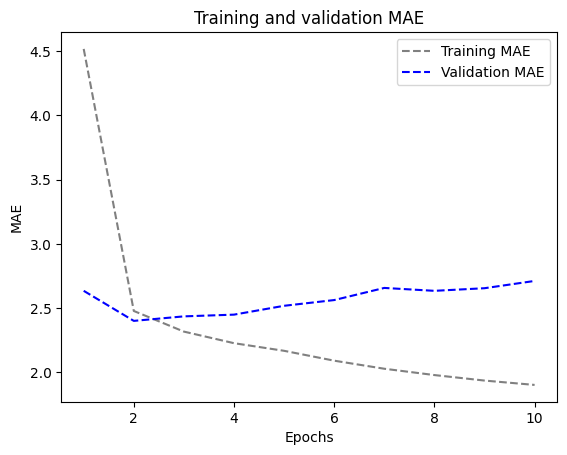

In [38]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**4.LSTM - Stacked setup with 32 units**

In [39]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 288s 346ms/step - loss: 19.6578 - mae: 3.1808 - val_loss: 10.2804 - val_mae: 2.5021
Epoch 2/10
819/819 [==============================] - 247s 301ms/step - loss: 7.7294 - mae: 2.1630 - val_loss: 10.8321 - val_mae: 2.5637
Epoch 3/10
819/819 [==============================] - 284s 346ms/step - loss: 6.2670 - mae: 1.9413 - val_loss: 12.5510 - val_mae: 2.7508
Epoch 4/10
819/819 [==============================] - 284s 346ms/step - loss: 5.2460 - mae: 1.7722 - val_loss: 12.9916 - val_mae: 2.8196
Epoch 5/10
819/819 [==============================] - 250s 305ms/step - loss: 4.5007 - mae: 1.6370 - val_loss: 13.4033 - val_mae: 2.8380
Epoch 6/10
819/819 [==============================] - 284s 347ms/step - loss: 3.9024 - mae: 1.5196 - val_loss: 13.9598 - val_mae: 2.9098
Epoch 7/10
819/819 [==============================] - 255s 311ms/step - loss: 3.5043 - mae: 1.4364 - val_loss: 14.4846 - val_mae: 2.9718
Epoch 8/10
819/819 [====================

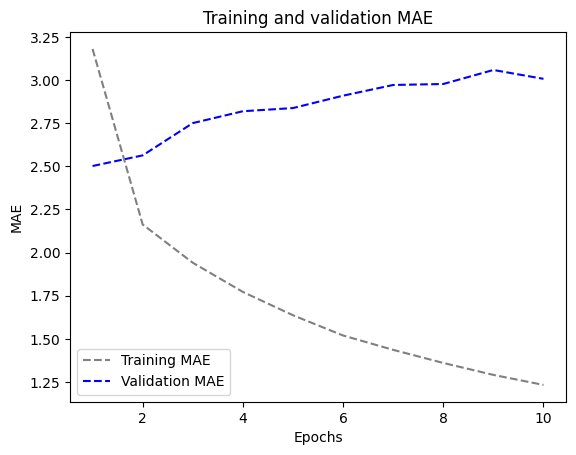

In [40]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**4.LSTM - Stacked setup with 8 units**

In [41]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 167s 199ms/step - loss: 71.4584 - mae: 6.4851 - val_loss: 37.0355 - val_mae: 4.5137
Epoch 2/10
819/819 [==============================] - 151s 184ms/step - loss: 22.3344 - mae: 3.5004 - val_loss: 13.8627 - val_mae: 2.8080
Epoch 3/10
819/819 [==============================] - 161s 196ms/step - loss: 11.6358 - mae: 2.6407 - val_loss: 10.3696 - val_mae: 2.5055
Epoch 4/10
819/819 [==============================] - 157s 191ms/step - loss: 10.1030 - mae: 2.4804 - val_loss: 9.4182 - val_mae: 2.3879
Epoch 5/10
819/819 [==============================] - 169s 206ms/step - loss: 9.6770 - mae: 2.4324 - val_loss: 9.5526 - val_mae: 2.4115
Epoch 6/10
819/819 [==============================] - 163s 199ms/step - loss: 9.3672 - mae: 2.3929 - val_loss: 8.9796 - val_mae: 2.3300
Epoch 7/10
819/819 [==============================] - 164s 199ms/step - loss: 9.0602 - mae: 2.3542 - val_loss: 8.8835 - val_mae: 2.3034
Epoch 8/10
819/819 [=====================

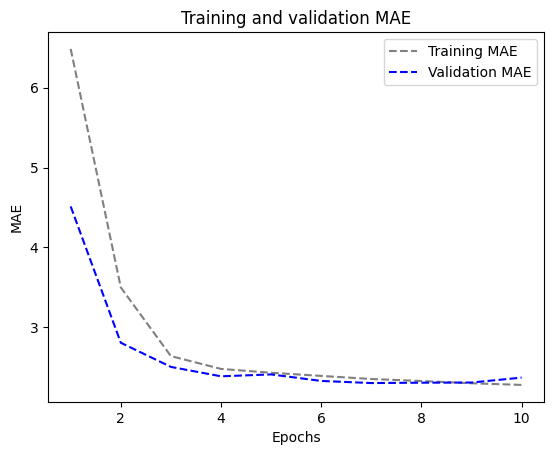

In [42]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**5.LSTM - dropout-regularized, stacked model**

In [43]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 271s 325ms/step - loss: 72.6522 - mae: 6.5508 - val_loss: 34.6757 - val_mae: 4.3884
Epoch 2/10
819/819 [==============================] - 272s 331ms/step - loss: 31.6224 - mae: 4.2181 - val_loss: 13.9650 - val_mae: 2.7925
Epoch 3/10
819/819 [==============================] - 272s 332ms/step - loss: 24.5615 - mae: 3.7505 - val_loss: 11.1867 - val_mae: 2.5673
Epoch 4/10
819/819 [==============================] - 268s 327ms/step - loss: 22.6435 - mae: 3.6104 - val_loss: 10.8404 - val_mae: 2.5390
Epoch 5/10
819/819 [==============================] - 258s 314ms/step - loss: 21.3638 - mae: 3.5102 - val_loss: 10.1880 - val_mae: 2.4653
Epoch 6/10
819/819 [==============================] - 261s 319ms/step - loss: 20.3786 - mae: 3.4344 - val_loss: 9.8552 - val_mae: 2.4392
Epoch 7/10
819/819 [==============================] - 275s 336ms/step - loss: 19.5037 - mae: 3.3663 - val_loss: 9.7018 - val_mae: 2.4204
Epoch 8/10
819/819 [================

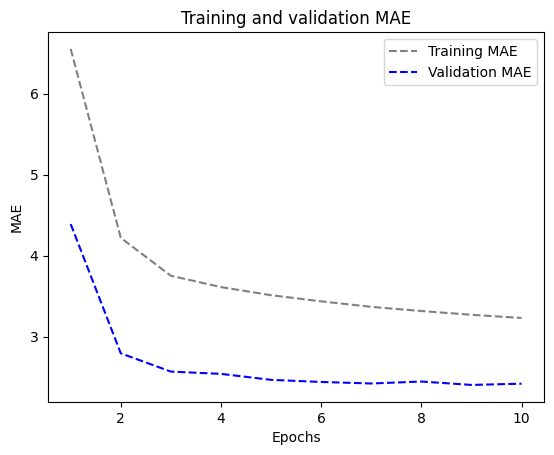

In [44]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**6. Bidirectional LSTM**

In [45]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 166s 196ms/step - loss: 27.0466 - mae: 3.7328 - val_loss: 10.6734 - val_mae: 2.5394
Epoch 2/10
819/819 [==============================] - 156s 190ms/step - loss: 9.5604 - mae: 2.4115 - val_loss: 9.6774 - val_mae: 2.4199
Epoch 3/10
819/819 [==============================] - 153s 186ms/step - loss: 8.6406 - mae: 2.2883 - val_loss: 9.7280 - val_mae: 2.4276
Epoch 4/10
819/819 [==============================] - 154s 188ms/step - loss: 8.0362 - mae: 2.2090 - val_loss: 9.8251 - val_mae: 2.4324
Epoch 5/10
819/819 [==============================] - 161s 196ms/step - loss: 7.6009 - mae: 2.1490 - val_loss: 9.8496 - val_mae: 2.4279
Epoch 6/10
819/819 [==============================] - 163s 199ms/step - loss: 7.2491 - mae: 2.1003 - val_loss: 10.1469 - val_mae: 2.4699
Epoch 7/10
819/819 [==============================] - 156s 190ms/step - loss: 6.9529 - mae: 2.0574 - val_loss: 9.9412 - val_mae: 2.4365
Epoch 8/10
819/819 [=========================

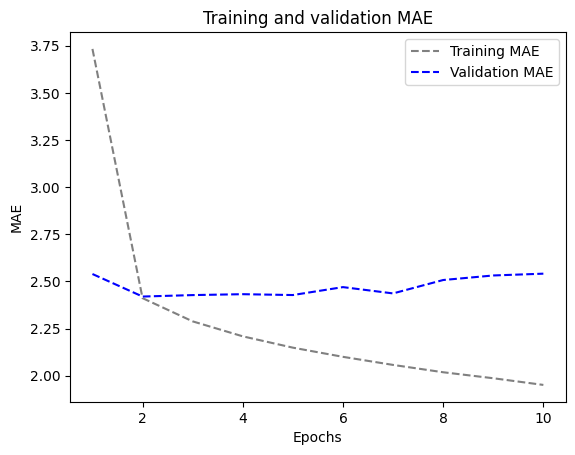

In [46]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**1D Convnets and LSTM together**

In [47]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 117s 140ms/step - loss: 49.8492 - mae: 5.2829 - val_loss: 31.7686 - val_mae: 4.3797
Epoch 2/10
819/819 [==============================] - 132s 161ms/step - loss: 17.9138 - mae: 3.2583 - val_loss: 22.3645 - val_mae: 3.7028
Epoch 3/10
819/819 [==============================] - 134s 163ms/step - loss: 14.7419 - mae: 2.9767 - val_loss: 23.3027 - val_mae: 3.8847
Epoch 4/10
819/819 [==============================] - 138s 169ms/step - loss: 13.0552 - mae: 2.7967 - val_loss: 24.1605 - val_mae: 3.8643
Epoch 5/10
819/819 [==============================] - 116s 141ms/step - loss: 11.8949 - mae: 2.6610 - val_loss: 22.0105 - val_mae: 3.7677
Epoch 6/10
819/819 [==============================] - 116s 141ms/step - loss: 10.8960 - mae: 2.5457 - val_loss: 22.9830 - val_mae: 3.7645
Epoch 7/10
819/819 [==============================] - 114s 139ms/step - loss: 10.1881 - mae: 2.4556 - val_loss: 22.7887 - val_mae: 3.8321
Epoch 8/10
819/819 [==============

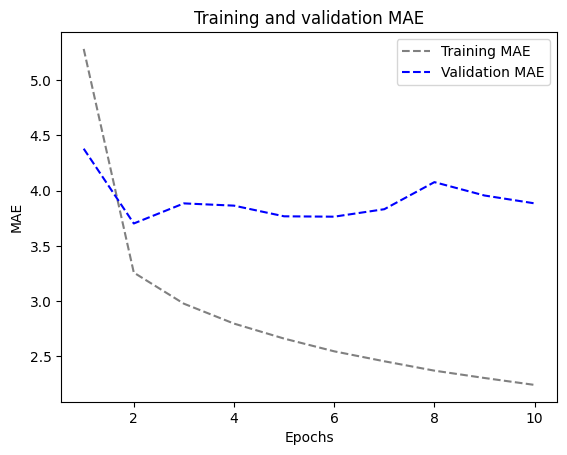

In [48]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

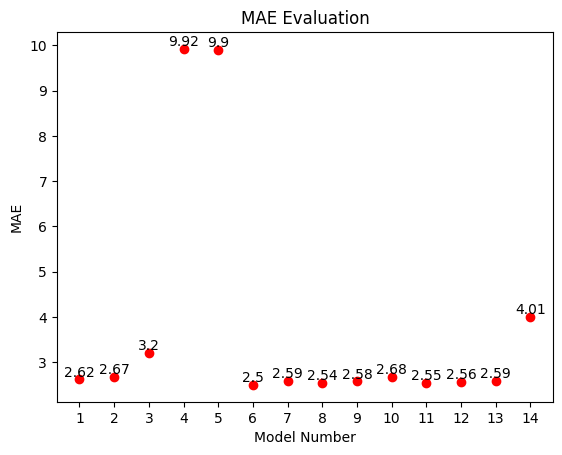

In [49]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.67,3.2,9.92,9.9,2.5,2.59,2.54,2.58,2.68,2.55,2.56,2.59,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()